## Distribution-free Tolerance Intervals

Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.optimize as opt

Definitions and Datasets

In [2]:
nice_purple = [95/256, 75/256, 139/256]

In [3]:
## measurements of concentration from Example 5.1 in 'Statistical Intervals A Guide for Practitioners and Researchers' 
## by William Q. Meeker, Gerald J. Hahn, Luis A. Escobar (page 76)

concentration_test_data=[1.49,1.66,2.05,2.24,2.29,2.69,2.77,2.77,3.10,3.23,\
3.28,3.29,3.31,3.36,3.84,4.04,4.09,4.13,4.14,4.16,\
4.57,4.63,4.83,5.06,5.17,5.19,5.89,5.97,6.28,6.38,\
6.51,6.53,6.54,6.55,6.83,7.08,7.28,7.53,7.54,7.68,\
7.81,7.87,7.94,8.43,8.70,8.97,8.98,9.13,9.14,9.22,\
9.24,9.30,9.44,9.69,9.86,9.99,11.28,11.37,12.03,12.32,\
12.93,13.03,13.09,13.43,13.58,13.70,14.17,14.36,14.96,15.89,\
16.57,16.60,16.85,17.18,17.46,17.74,18.40,18.78,19.84,20.45,\
20.89,22.28,22.48,23.66,24.33,24.72,25.46,25.67,25.77,26.64,\
28.28,28.28,29.07,29.16,31.14,31.83,33.24,37.32,53.43,58.11]

# let's shuffle it to make it look like it's come from measurements (because we don't know the actual ordering, only the 
# order statistics are shown)
np.random.shuffle(concentration_test_data)

## ratings of coffee and coconuts on tripadvisor 589 ratings
candc_ratings = np.concatenate([np.repeat(5, 310),np.repeat(4, 170),np.repeat(3, 65),np.repeat(2, 24),np.repeat(1, 20)])
# shuffle them to simulate the reviews coming in in real time
np.random.shuffle(candc_ratings)

## ratings of oeuf on tripadvisor 14 ratings
oeuf_ratings = np.concatenate([np.repeat(5, 11),np.repeat(1, 3)])
# shuffle them to simulate the reviews coming in in real time
np.random.shuffle(oeuf_ratings)

## ratings of little collins on tripadvisor 318 ratings
lilcol_ratings = np.concatenate([np.repeat(5, 210),np.repeat(4, 67),np.repeat(3, 19),np.repeat(2, 11),np.repeat(1, 11)])
# shuffle them to simulate the reviews coming in in real time
np.random.shuffle(lilcol_ratings)
 

Functions

In [4]:
def weib(x,lmbd,k):
    """ Calculate Weibull pdf for two parameters lambda (lmbd) and k
    """
    return (k / lmbd) * (x / lmbd)**(k - 1) * np.exp(-(x / lmbd)**k)

def one_side_upper_conf_bound(p, X, oneminalpha):
    """ Calculate an interpolated upper confidence bound for the quantile p in sample X
        with upper confidence bound oneminalpha as per page 81 in 'Statistical Intervals A Guide 
        for Practitioners and Researchers' by William Q. Meeker, Gerald J. Hahn, Luis A. Escobar
    """
    
    # sort samples
    X = np.sort(X)

    # count number of samples
    n = len(X)

    u_c = np.int(st.binom.ppf(oneminalpha, n, p)+1)
    # now need to find the next order statistic < X[u_c-1]
    # concat [0] means that we pick the first entry if there is no value of X < X[u_c-1]
    u_n = np.concatenate([[0],np.arange(1,len(X)+1)[X<X[u_c-1]]])[-1]
    
    #print('X[u_c] = {}, X[u_n] = {}'.format(X[u_c], X[u_n]))
    if X[u_c-1] == X[u_n-1]:
        print('Upper conf bound interpolation not possible')
        omega = 1
    else:
        omega = (oneminalpha - st.binom.cdf(u_n-1, n, p))/(st.binom.cdf(u_c-1, n, p) - st.binom.cdf(u_n-1, n, p))
    
    return omega*X[u_c-1] + (1 - omega)*X[u_n-1]

def one_side_lower_conf_bound(p, X, oneminalpha):
    """ Calculate an interpolated lower confidence bound for the quantile p in sample X
        with lower confidence bound oneminalpha as per page 82 in 'Statistical Intervals A Guide 
        for Practitioners and Researchers' by William Q. Meeker, Gerald J. Hahn, Luis A. Escobar
    """
    
    # sort samples
    X = np.sort(X)

    # count number of samples
    n = len(X)

    l_c = n - np.int(st.binom.ppf(oneminalpha, n, 1-p))
    # now need to find the next order statistic > X[l_c-1]
    # concat [len(X)-1] means that we pick the last entry if there is no value of X > X[l_c]
    l_n = np.concatenate([np.arange(1,len(X)+1)[X>X[l_c-1]],[len(X)-1]])[0]

    #print('X[l_c] = {}, X[l_n] = {}'.format(X[l_c], X[l_n]))
    if X[l_c-1] == X[l_n-1]:
        print('Lower conf bound interpolation not possible')
        omega = 1
    else:
        omega = (oneminalpha - (1-st.binom.cdf(l_n-1, n, p)))/((1-st.binom.cdf(l_c-1, n, p)) - (1-st.binom.cdf(l_n-1, n, p)))
    
    return omega*X[l_c-1] + (1 - omega)*X[l_n-1]

def two_sided_conf_bound(p, X, oneminalpha):
    """ Calculate an interpolated two-sided confidence bound for the quantile p in sample X
        with confidence interval oneminalpha as per page 82 in 'Statistical Intervals A Guide 
        for Practitioners and Researchers' by William Q. Meeker, Gerald J. Hahn, Luis A. Escobar
    """
    
    # calculate 100(1 − α/2)% upper conf bound
    upper_bound = one_side_upper_conf_bound(p, X, 1-(1-oneminalpha)/2)
    
    # calculate 100(1 + α/2)% lower conf bound
    lower_bound = one_side_lower_conf_bound(p, X, 1-(1-oneminalpha)/2)
    
    return [lower_bound, upper_bound]

def two_sided_tol_intrvls(beta, X, oneminalpha):
    """ Calculate tolerance intervals for containing a fraction of the population
        beta given sample X from that population, with confidence oneminalpha as 
        per page 86 in 'Statistical Intervals A Guide for Practitioners and 
        Researchers' by William Q. Meeker, Gerald J. Hahn, Luis A. Escobar
    """
    
    # sort samples
    X = np.sort(X)

    # count number of samples
    n = len(X)
    
    nu = n - np.int(st.binom.ppf(oneminalpha, n, beta))
    
    if nu < 2:
        print("""No two-sided distribution-free tolerance interval containing 
at least a proportion β with coverage probability greater than 
or equal to 1 − α possible.""")
        return [0,0]
    
    if nu%2:
        # nu is odd
        nu_1 = nu/2 - 0.5
        nu_2 = nu_1 + 1
    else:
        # nu is even
        nu_1 = nu/2
        nu_2 = nu/2
    
    nu_1 = int(nu_1)
    nu_2 = int(nu_2)
    
    l = nu_1
    u = n - nu_2 +1
    
    print('Confidence bound = {:.3f} (desired = {})'.format(st.binom.cdf(u-l-1, n, beta),oneminalpha))
    tol_bounds = [X[l-1], X[u-1]]
    
    return tol_bounds

def two_sided_interp_tol_intrvls(beta, X, oneminalpha):
    """ Calculate interpolated tolerance intervals for containing a fraction of the population
        beta given sample X from that population, with confidence oneminalpha as 
        per page 87 in 'Statistical Intervals A Guide for Practitioners and 
        Researchers' by William Q. Meeker, Gerald J. Hahn, Luis A. Escobar
    """
    
    # sort samples
    X = np.sort(X)

    # count number of samples
    n = len(X)
    
    nu = n - np.int(st.binom.ppf(oneminalpha, n, beta))
    
    if nu < 2:
        print("""No two-sided distribution-free tolerance interval containing 
at least a proportion β with coverage probability greater than 
or equal to 1 − α possible.""")
        return [0,0]
    
    if nu%2:
        # nu is odd
        nu = nu -1
        
    l_c = int(nu/2)
    l_n = l_c + 1
    u_c = int(n - l_c + 1)
    u_n = int(n - l_n + 1)
    
    omega = (oneminalpha - st.binom.cdf(u_n-l_n-1, n, beta))/(st.binom.cdf(u_c-l_c-1, n, beta) - st.binom.cdf(u_n-l_n-1, n, beta))
    
    tol_bounds = [omega*X[l_c-1] + (1-omega)*X[l_n-1], omega*X[u_c-1] + (1-omega)*X[u_n-1]]
    
    return tol_bounds

def cond_on_n(n, beta, oneminalpha):
    """ Condition to be minimized for smallest n required for meaningful TI
        to be calculated, from page 89 in 'Statistical Intervals A Guide for Practitioners and 
        Researchers' by William Q. Meeker, Gerald J. Hahn, Luis A. Escobar
    """
    
    return (oneminalpha - (1-n*beta**(n-1) + (n-1)*beta**n))**2

def calc_min_n(beta, oneminalpha):
    """ Calculate the smallest n required to give meaningful interval for given beta and one minus alpha
    """
    
    res = opt.minimize_scalar(cond_on_n, args = (beta, oneminalpha))
    
    return np.ceil(res.x)

### Erlang distirbution

In [38]:
k = 2
lmbd = 7

n_samples = 5000

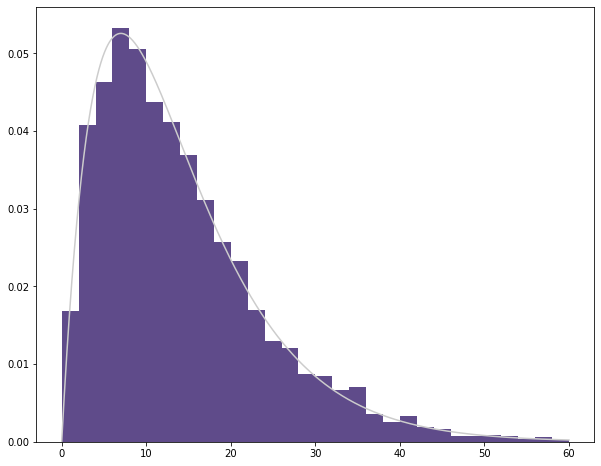

In [39]:
xmax = 60
binstep = 2
erlang_samp = st.erlang.rvs(size = n_samples , a= k, scale = lmbd)
x = np.arange(0, xmax, 0.001)
y = st.erlang.pdf(x, a= k, scale = lmbd)
fig, ax = plt.subplots(figsize = [10,8])
ax.hist(erlang_samp, density = 1, bins = np.arange(0,xmax+binstep, binstep), color = nice_purple)
ax.plot(x,y, color = [0.8, 0.8, 0.8])
plt.show()

In [40]:
st.erlang.ppf(0.5, a= k, scale = lmbd)

11.748428930116628

In [36]:
np.std(erlang_samp)

11.370535574373745

In [37]:
np.mean(erlang_samp)

15.962847702698518

In [11]:
two_sided_interp_tol_intrvls(0.68, erlang_samp, 0.95)

[5.0, 24.0]

In [12]:
np.quantile(erlang_samp, 0.16)

5.0

In [13]:
np.quantile(erlang_samp, 0.84)

23.0

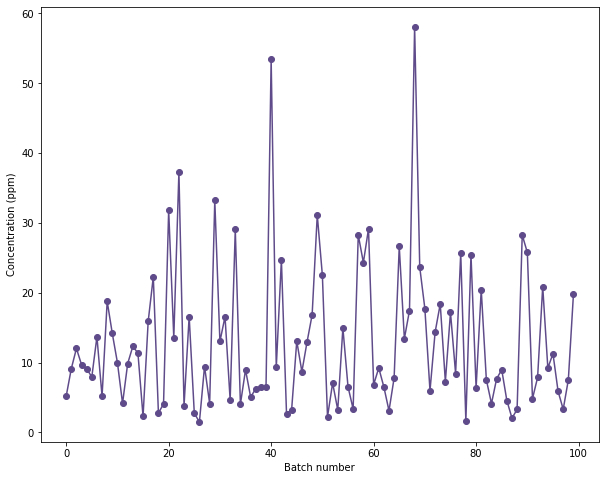

In [14]:
# make scatter plot (n.b. this won't look exactly lke in the book!)
fig, ax = plt.subplots(figsize = [10,8])
ax.plot(concentration_test_data,'o-', color = nice_purple)
ax.set_xlabel('Batch number')
ax.set_ylabel('Concentration (ppm)')
plt.show()

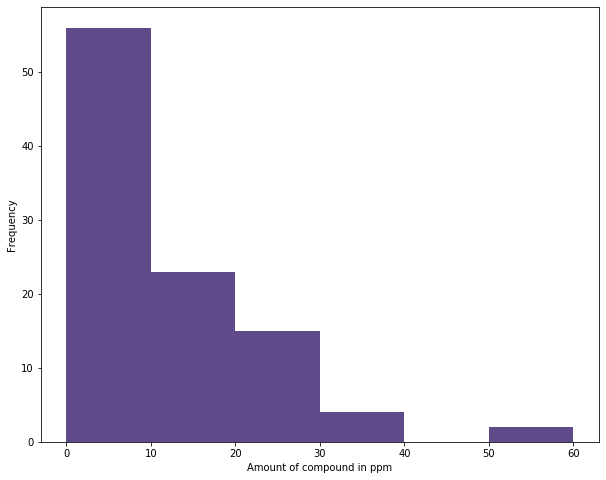

In [15]:
# make histogram
fig, ax = plt.subplots(figsize = [10,8])
ax.hist(concentration_test_data, color = nice_purple, bins = np.arange(0,70,10))
ax.set_xlabel('Amount of compound in ppm')
ax.set_ylabel('Frequency')
plt.show()

In [16]:
# Example 5.2
one_side_upper_conf_bound(0.9, concentration_test_data, 0.95)

31.294375537733927

In [17]:
# Example 5.3
one_side_upper_conf_bound(0.1, concentration_test_data, 0.95)

3.9781351364219306

In [18]:
# Example 5.4
one_side_lower_conf_bound(0.1, concentration_test_data, 0.95)

2.6005069346469982

In [19]:
# Example 5.5
one_side_lower_conf_bound(0.9, concentration_test_data, 0.95)

24.450636483977235

In [20]:
# Example 5.6
two_sided_conf_bound(0.5, concentration_test_data, 0.95)

[7.768712542438091, 12.513733454713574]

In [21]:
# Example 5.7
print(two_sided_conf_bound(0.1, concentration_test_data, 0.9))
print(two_sided_conf_bound(0.1, concentration_test_data, 0.95))

[2.6005069346469982, 3.9781351364219306]
[2.305223820975737, 4.078593058195633]


In [22]:
# Example 5.8
print(two_sided_conf_bound(0.9, concentration_test_data, 0.9))
print(two_sided_conf_bound(0.9, concentration_test_data, 0.95))

[24.450636483977235, 31.294375537733927]
[23.812853020178512, 31.803738908816854]


In [23]:
# Example 5.9
two_sided_tol_intrvls(0.9, concentration_test_data, 0.95)

Confidence bound = 0.976 (desired = 0.95)


[1.66, 37.32]

In [24]:
# Example 5.10
two_sided_interp_tol_intrvls(0.9, concentration_test_data, 0.95)

[1.9905918374677944, 39.774014098445704]

In [25]:
two_sided_conf_bound(0.5, candc_ratings,0.95)

[4.012707236871176, 4.9987866493998006]

In [26]:
two_sided_conf_bound(0.5, oeuf_ratings,0.95)

[4.33626373626374, 4.924907247093742]

In [27]:
two_sided_conf_bound(0.5, lilcol_ratings,0.95)

Lower conf bound interpolation not possible


[5, 4.999748715561946]